In [1]:
from math import pi
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

In [2]:
num_qubits=2
dev=qml.device('default.qubit', wires=num_qubits)

In [3]:
#Analytic Solution
def U(t):
    return np.sin(t)+1

In [4]:
def FE1(U_prime,t):         # U_prime = cos(t) , U(0)=1
    return U_prime - np.cos(t)


In [5]:
t=np.random.uniform(0,2*np.pi,size=100,requires_grad=False)

In [6]:
# define embedding layer
def embedding(x,wires):
    qml.RY(x, wires=wires[1])

In [7]:
def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

In [8]:
# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubit 1
    qml.RY(theta,wires=1)
    
    # CNOT
    qml.CNOT(wires=[0, 1])

In [9]:
@qml.qnode(dev, diff_method="backprop", interface="autograd")
def quantum_net(theta,x):
    
    # encode data
    embedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # print(v)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    # return qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1))
    return qml.expval(qml.PauliZ(0))

In [10]:
num_layers=4
theta=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
# theta = np.load('my_theta1.npy')
print(theta)
print(qml.draw(quantum_net)(theta,0))

[[0.44875154]
 [1.06482504]
 [2.81060341]
 [2.38159632]]
0: ──H────────────────╭●──H──────╭●──H──────╭●──H──────╭●──H─┤  <Z>
1: ──RY(0.00)──RY(M0)─╰X──RY(M1)─╰X──RY(M2)─╰X──RY(M3)─╰X────┤     


In [11]:
# add the classical layer   #TODO
def classical_quantum_net(theta,w,t):
    r1=quantum_net(theta,t)[0]
    # r2=quantum_net(theta,x)[1]
    # return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[4]*r2**2
    return w[0]+w[1]*r1+w[2]*r1**2
    # r1=quantum_net(theta,t)[0]
    # return r1

In [12]:
def classical_quantum_net_prime(theta,w,t):
    r1=quantum_net(theta,t)[0]
    r1_prime = qml.grad(quantum_net,argnum=1)(theta,np.tensor(t)) 
    # r2=quantum_net(theta,x)[1]
    # return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[4]*r2**2
    return w[1]*r1_prime+2*w[2]*r1_prime*r1


In [13]:
# def square_loss(labels,predictions):
#     loss=0
#     for l,p in zip(labels,predictions):
#         loss=loss+(l-p)**2
#     loss=loss/len(labels)
#     return loss

In [14]:
# #loss boundary
# def loss_b(U_predict):
    
    

In [15]:

def cost(theta,w,t):
# def cost(theta,t):
    # loss inner points
    loss_i = 0
    # U_prime = np.array([qml.grad(quantum_net,argnum=1)(theta,np.tensor(point)) for point in t])
    U_prime = np.array([classical_quantum_net_prime(theta,w,point) for point in t])
    # preds=[classical_quantum_net(theta,w,t) for t in t]
    loss_i += np.mean(FE1(U_prime=U_prime,t=t)**2)
    
    # loss boundary points
    loss_b = 0
    U_0 = classical_quantum_net(theta,w,0)
    # print(U_0)
    loss_b += (U_0-1)**2
    return 0.2*loss_b + 0.8*loss_i

In [16]:
w=np.zeros(5,requires_grad=True)
opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

In [17]:
start=now()
print(start)

2023-07-31 16:49:53.063449


In [18]:
epochs=130
for e in range(1,epochs+1):
    (theta,w,_),_cost=opt.step_and_cost(cost,theta,w,t)
    # (theta,_),_cost=opt.step_and_cost(cost,theta,t)
    if e==1 or e%10==0:
        print(f'Epoch: {e} | Cost: {_cost}')

Epoch: 1 | Cost: 0.5757659703164897
Epoch: 10 | Cost: 0.37225479061205563
Epoch: 20 | Cost: 0.23094633066490144
Epoch: 30 | Cost: 0.05719729632054967
Epoch: 40 | Cost: 0.02531306876306735
Epoch: 50 | Cost: 0.019835096816853824
Epoch: 60 | Cost: 0.008428133926604435
Epoch: 70 | Cost: 0.003184624198900419
Epoch: 80 | Cost: 0.00114492600739512
Epoch: 90 | Cost: 0.00031830346801006026


KeyboardInterrupt: 

In [19]:
pred_train=np.array([classical_quantum_net(theta,w,t) for t in t])

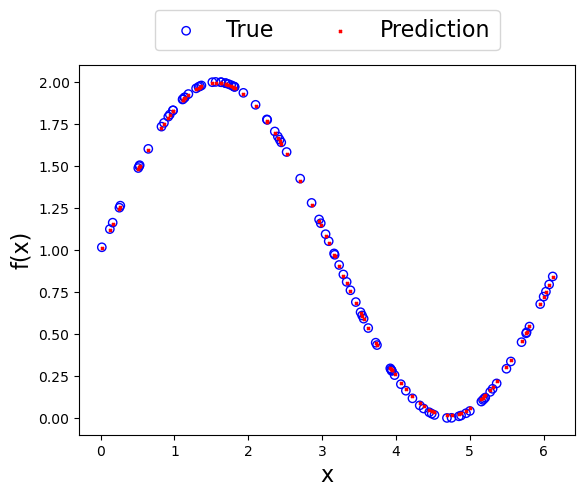

In [20]:
plt.figure()
plt.scatter(t,U(t),facecolors='none', edgecolors='b', label='True')
plt.scatter(t,pred_train, color='red',marker="x",s=4,label='Prediction')
plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
# plt.savefig('1_measurement2_train.png')
plt.show()